In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, confusion_matrix
from datetime import datetime, timedelta

In [2]:
# Load data into a pandas DataFrame
crops = pd.read_csv('singapore_plants.csv')

# Extract features containing only the temperature, humidity, ph, month and label columns
features = ['temperature', 'humidity', 'soil moisture','rainfall']

labels = crops['label']

X = crops[features]
y = crops['harvest time']

print(X)

     temperature  humidity  soil moisture  rainfall
0        21.1268   76.6881         0.6029     163.2
1        28.2850   73.0897         0.7293     163.2
2        22.3322   81.4227         0.7744     163.2
3        25.2706   70.8545         0.5939     163.2
4        21.8061   71.9626         0.7863     163.2
..           ...       ...            ...       ...
295      20.9698   79.5210         0.6660     145.2
296      27.0832   80.4632         0.4976     145.2
297      27.1782   65.9186         0.5986     145.2
298      32.9361   61.9459         0.6207     145.2
299      31.1790   75.6309         0.5486     145.2

[300 rows x 4 columns]


In [3]:
# Convert categorical features to numerical values and normalize the data
label_encoder = LabelEncoder()
month_encoder = LabelEncoder()
# X['month'] = label_encoder.fit_transform(X['month'])
# X['label'] = label_encoder.fit_transform(X['label'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 6, 7, 8, 9],
    'max_features': ['sqrt', 'log2', 0.5, 10, None]
}

# Initialize the model
model = RandomForestRegressor(random_state=42)

# Create a  KFold object for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform GridSearchCV with KFold cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Make predictions on the test data using the best model
test_pred = grid_search.best_estimator_.predict(X_test)

# Calculate the RMSE on the test set
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print(f"Test Root Mean Square Error for all crops: {test_rmse:.2f}")

# Print the best hyperparameters and score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Best hyperparameters:  {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 500}
Best cross-validation score:  -176.72895328768078


Test Root Mean Square Error: 11.41


C:\Users\wan_n\AppData\Local\Temp\ipykernel_94880\1305412049.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(unique_labels))


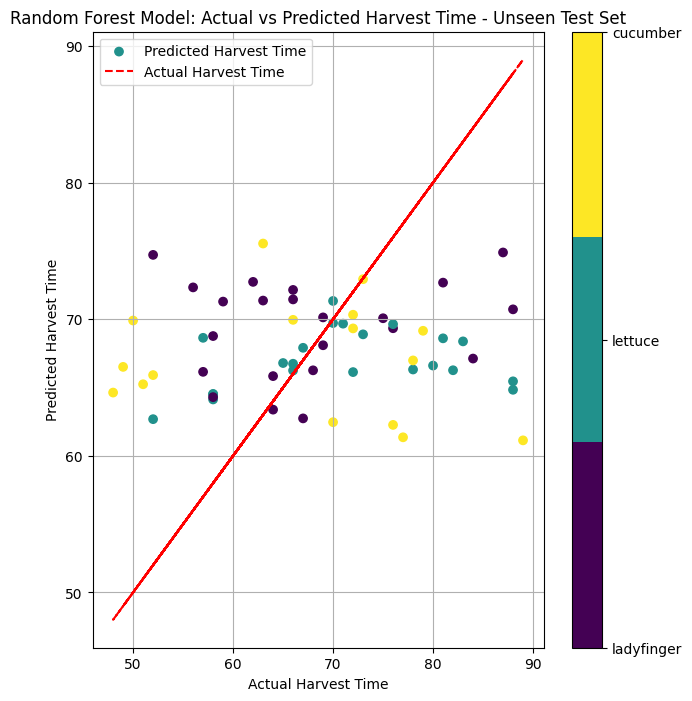

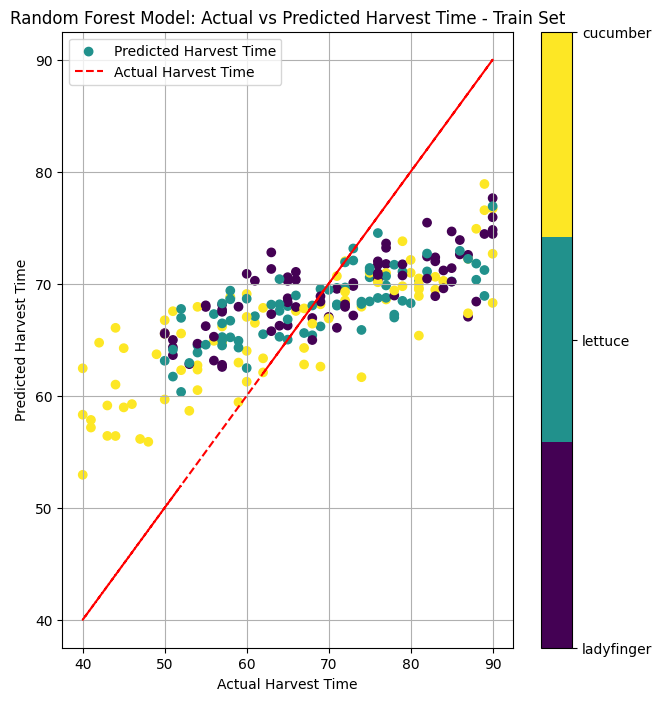

In [5]:
# Add the predicted harvest time to your test set
X_test['predicted_harvest'] = test_pred

# Convert the numerical labels back to original crop names
X_test['label'] = labels.loc[X_test.index]

# Convert 'label' to numeric for plotting
X_test['label_numeric'] = X_test['label'].astype('category').cat.codes

# Get the unique crop types
unique_labels = X_test['label'].unique()

# Create a color map with a different color for each unique crop type
cmap = plt.cm.get_cmap('viridis', len(unique_labels))
colors = [cmap(i) for i in range(len(unique_labels))]
crop_type_colors = dict(zip(unique_labels, colors))

# Create the scatter plot with a colormap for the test set
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
scatter = plt.scatter(y_test, test_pred, c=X_test['label_numeric'], cmap=cmap, label='Predicted Harvest Time')
cbar = plt.colorbar(scatter, ticks=range(len(unique_labels)))
cbar.ax.set_yticklabels(unique_labels)
plt.plot(y_test, y_test, color='red', linestyle='--', label='Actual Harvest Time')
plt.xlabel('Actual Harvest Time')
plt.ylabel('Predicted Harvest Time')
plt.title('Random Forest Model: Actual vs Predicted Harvest Time - Unseen Test Set')
# plt.ylim(35, 100)
# plt.xlim(35, 100)
plt.legend()
plt.grid(True)

# Create the scatter plot with a colormap for the train set
train_pred = grid_search.best_estimator_.predict(X_train)

X_train['predicted_harvest'] = train_pred

X_train['label'] = labels.loc[X_train.index]

# Convert 'label' to numeric for plotting
X_train['label_numeric'] = X_train['label'].astype('category').cat.codes

plt.figure(figsize=(16, 8))
plt.subplot(1,2,2)
scatter = plt.scatter(y_train, train_pred, c=X_train['label_numeric'], cmap=cmap, label='Predicted Harvest Time')
cbar = plt.colorbar(scatter, ticks=range(len(unique_labels)))
cbar.ax.set_yticklabels(unique_labels)
plt.plot(y_train, y_train, color='red', linestyle='--', label='Actual Harvest Time')
plt.xlabel('Actual Harvest Time')
plt.ylabel('Predicted Harvest Time')
plt.title('Random Forest Model: Actual vs Predicted Harvest Time - Train Set')
# plt.ylim(35, 100)
# plt.xlim(35, 100)
plt.legend()
plt.grid(True)

Index(['temperature', 'humidity', 'soil moisture', 'rainfall'], dtype='object')
Shape of crop_features.columns:  (4,)
Shape of feature_importances:  (4,)


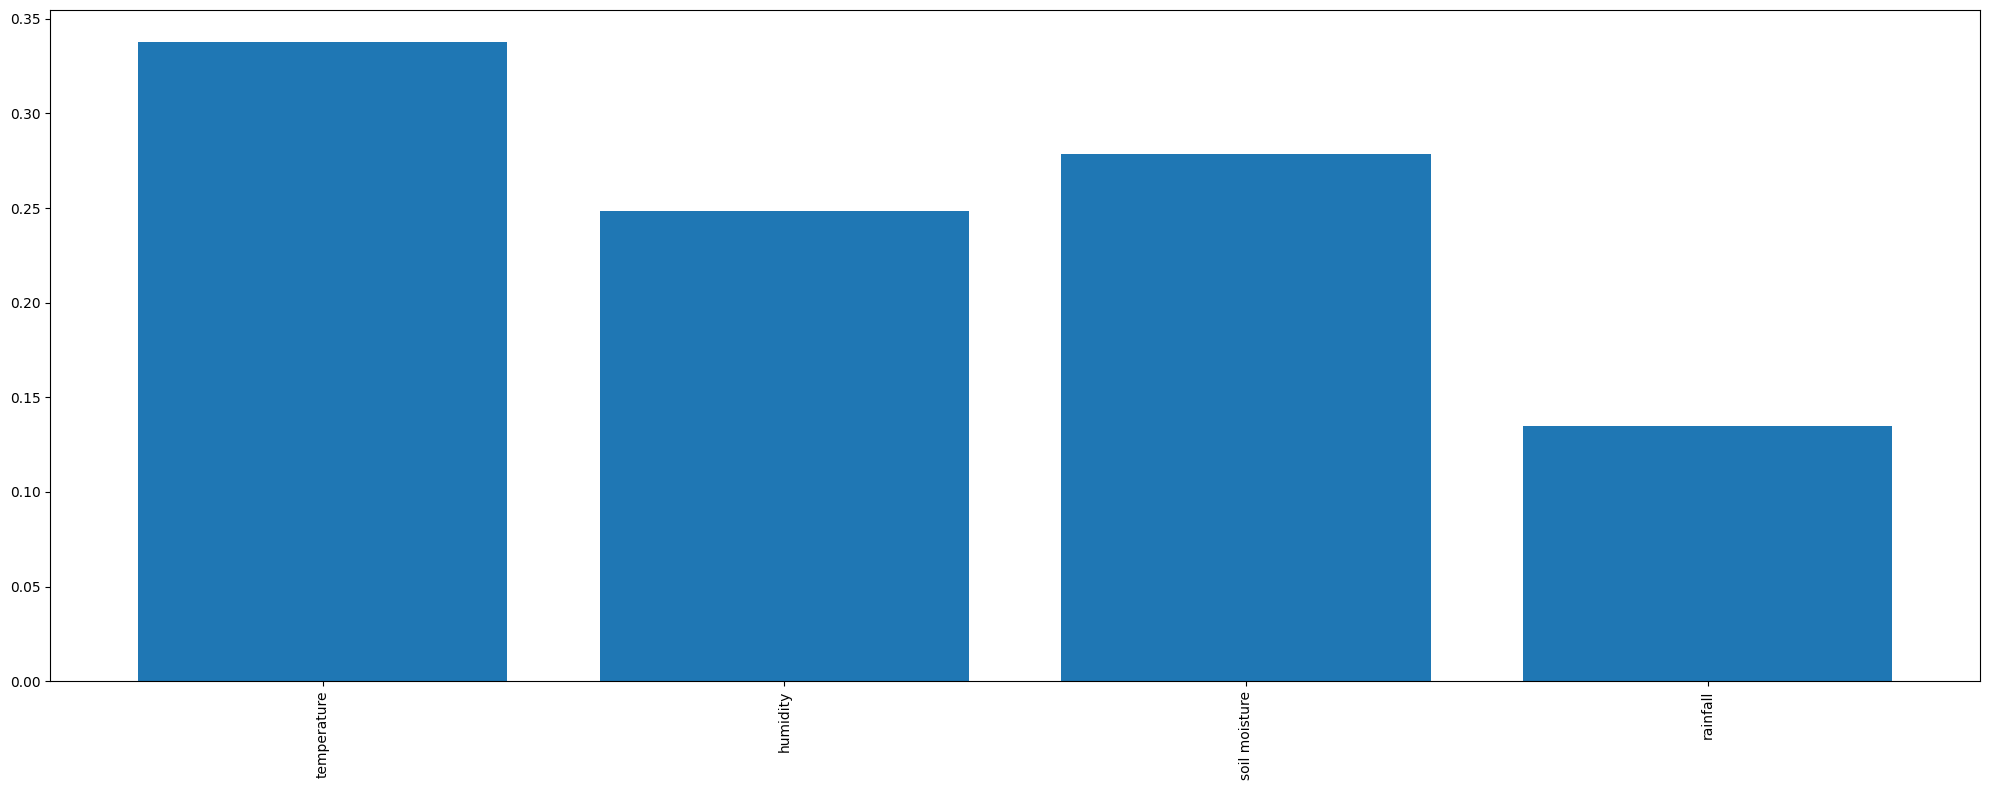

In [ ]:
crop_features = crops.drop(['yield percentage', 'irrigation frequency', 'month', 'label','harvest time'], axis=1)
feature_importances = grid_search.best_estimator_.feature_importances_
print(crop_features.columns)
print("Shape of crop_features.columns: ", crop_features.columns.shape)
print("Shape of feature_importances: ", feature_importances.shape)
plt.figure(figsize=(20, 8))
plt.bar(crop_features.columns, feature_importances)
plt.xticks(rotation=90)
plt.tight_layout()

C:\Users\wan_n\AppData\Local\Temp\ipykernel_89128\1736402748.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(unique_labels_freq))


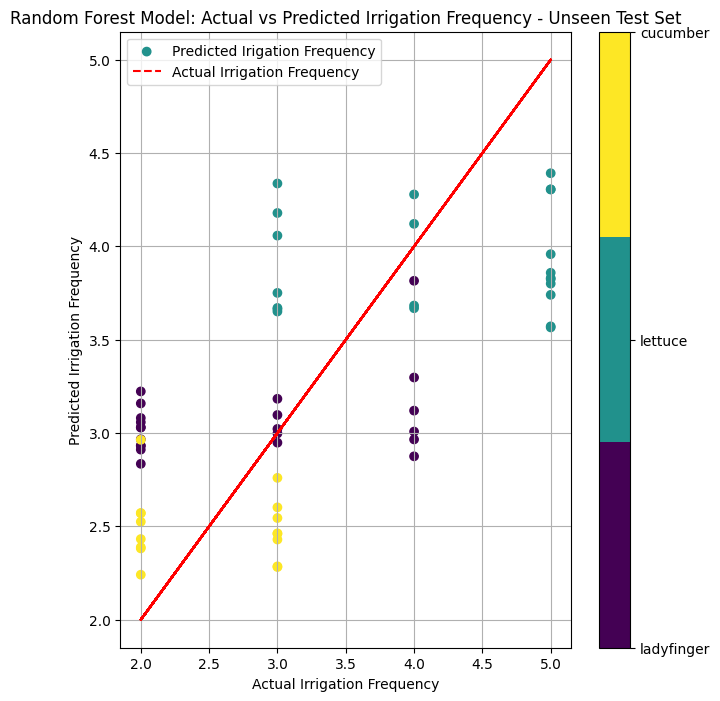

In [ ]:
x_freq = crops[features]
y_freq = crops['irrigation frequency']

X_train_freq, X_test_freq, y_train_freq, y_test_freq = train_test_split(x_freq, y_freq, test_size=0.2, random_state=42)

# Initialize the model
freq_model = RandomForestRegressor(random_state=42)

# Perform GridSearchCV with KFold cross-validation
freq_grid_search = GridSearchCV(estimator=freq_model, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
freq_grid_search.fit(X_train_freq, y_train_freq)

freq_pred = freq_grid_search.best_estimator_.predict(X_test_freq)

X_test_freq['predicted_frequency'] = freq_pred

# Convert the numerical labels back to original crop names
X_test_freq['label'] = labels.loc[X_test_freq.index]

# Convert 'label' to numeric for plotting
X_test_freq['label_numeric'] = X_test_freq['label'].astype('category').cat.codes

# Get the unique crop types
unique_labels_freq = X_test_freq['label'].unique()

# Create a color map with a different color for each unique crop type
cmap = plt.cm.get_cmap('viridis', len(unique_labels_freq))
colors = [cmap(i) for i in range(len(unique_labels_freq))]
crop_type_colors = dict(zip(unique_labels_freq, colors))

# Create the scatter plot with a colormap for the test set
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
scatter = plt.scatter(y_test_freq, freq_pred, c=X_test_freq['label_numeric'], cmap=cmap, label='Predicted Irigation Frequency')
cbar = plt.colorbar(scatter, ticks=range(len(unique_labels_freq)))
cbar.ax.set_yticklabels(unique_labels_freq)
plt.plot(y_test_freq, y_test_freq, color='red', linestyle='--', label='Actual Irrigation Frequency')
plt.xlabel('Actual Irrigation Frequency')
plt.ylabel('Predicted Irrigation Frequency')
plt.title('Random Forest Model: Actual vs Predicted Irrigation Frequency - Unseen Test Set')
plt.legend()
plt.grid(True)

Predicted harvest time for ladyfinger: 68.65771703657539 days
Estimated harvest date for ladyfinger: 30/06/24
RMSE for ladyfinger: 11.81


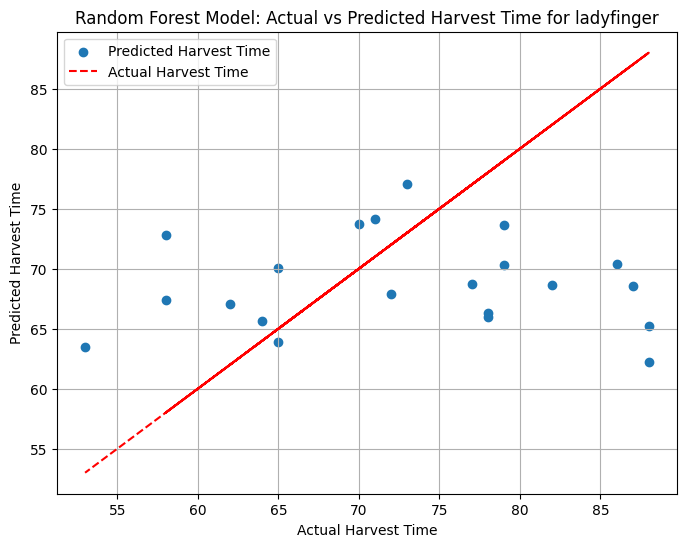

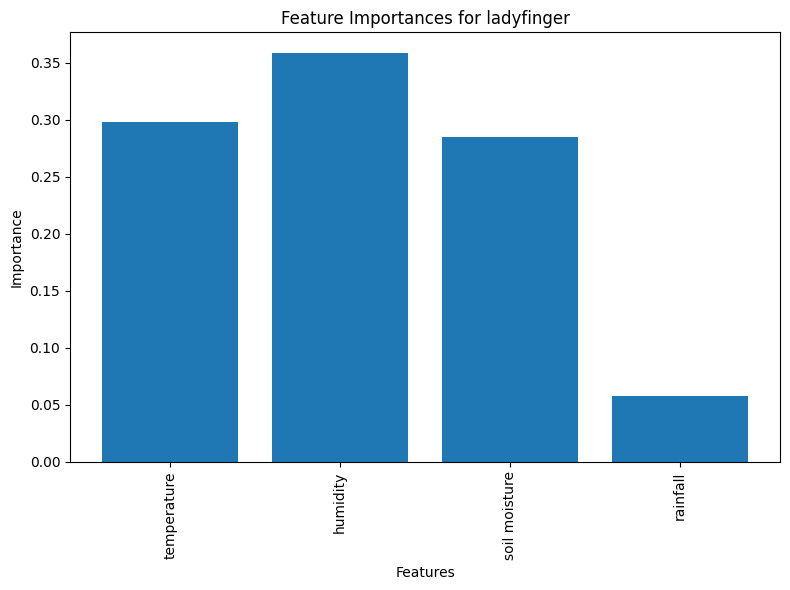

In [ ]:
# Ask the user to input the crop type
crop_type = input("Enter the crop type you want to analyze: ")
start_date = input("Enter start date (DD/MM/YY): ")

# Filter the dataset to include only the specified crop type
crop_data = crops[crops['label'] == crop_type]

# Check if the crop type exists in the dataset
if crop_data.empty:
    print(f"No data found for crop type: {crop_type}")
else:
    # Extract features and labels for the filtered dataset
    crop_features = ['temperature', 'humidity', 'soil moisture', 'rainfall']
    X_crop = crop_data[crop_features]
    y_crop = crop_data['harvest time']

    # Split the data into training and testing sets
    X_train_crop, X_test_crop, y_train_crop, y_test_crop = train_test_split(X_crop, y_crop, test_size=0.2, random_state=42)

    # Train the Random Forest Regressor model with GridSearchCV
    grid_search.fit(X_train_crop, y_train_crop)

    # Make predictions on the test data
    y_pred_crop = grid_search.best_estimator_.predict(X_test_crop)

    # Print the predicted harvest time
    print(f"Predicted harvest time for {crop_type}: {y_pred_crop[0]} days")

    # Parse the start date
    start_date = datetime.strptime(start_date, "%d/%m/%y")

    # Calculate the estimated harvest date
    estimated_harvest_date = start_date + timedelta(days=y_pred_crop[0])
    print(f"Estimated harvest date for {crop_type}: {estimated_harvest_date.strftime('%d/%m/%y')}")

    # Calculate the RMSE for the specific crop type
    crop_rmse = np.sqrt(mean_squared_error(y_test_crop, y_pred_crop))
    print(f"RMSE for {crop_type}: {crop_rmse:.2f}")

    # Plot actual vs predicted harvest time for the specific crop type
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test_crop, y_pred_crop, label='Predicted Harvest Time')
    plt.plot(y_test_crop, y_test_crop, color='red', linestyle='--', label='Actual Harvest Time')
    plt.xlabel('Actual Harvest Time')
    plt.ylabel('Predicted Harvest Time')
    plt.title(f'Random Forest Model: Actual vs Predicted Harvest Time for {crop_type}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Get feature importances for the specific crop type
    feature_importances_crop = grid_search.best_estimator_.feature_importances_
    plt.figure(figsize=(8, 6))
    plt.bar(features, feature_importances_crop)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title(f'Feature Importances for {crop_type}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [ ]:
# month_model = RandomForestClassifier(random_state=42)
# label_model = RandomForestClassifier(random_state=42)

# # Prepare the training data for month model
# X_month = crops[['temperature', 'humidity', 'soil moisture', 'rainfall']]
# y_month = month_encoder.fit_transform(crops['month'])

# # Split features and labels for crop label prediction
# X_label = crops[['temperature', 'humidity', 'soil moisture', 'rainfall']]
# y_label = label_encoder.fit_transform(crops['label'])

# X_train_month, X_test_month, y_train_month, y_test_month = train_test_split(X_month, y_month, test_size=0.2, random_state=42)
# X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(X_label, y_label, test_size=0.2, random_state=42)

# # Train the month model
# month_model.fit(X_train_month, y_train_month)

# # Train the label model
# label_model.fit(X_train_label, y_train_label)

# # Make predictions on the test data using the best model
# y_pred_month = month_model.predict(X_test_month)
# y_pred_label = label_model.predict(X_test_label)

In [ ]:
# def predict_harvest_time(temperature, humidity, soil_moisture, rainfall):
#     try: 
#         # Check if the input values are valid
#         if not isinstance(temperature, (int, float)) or temperature < 0:
#             raise ValueError("Temperature must be a positive number.")
#         if not isinstance(humidity, (int, float)) or humidity < 0 or humidity > 100:
#             raise ValueError("Humidity must be a number between 0 and 100.")
#         if not isinstance(soil_moisture, (int, float)) or soil_moisture < 0 or soil_moisture > 1:
#             raise ValueError("Soil moisture must be a number between 0 and 1.")
#         if not isinstance(rainfall, (int, float)) or rainfall < 0:
#             raise ValueError("Rainfall must be a positive number.")

#         # Create a DataFrame with user inputs
#         user_input = pd.DataFrame({
#             'temperature': [temperature],
#             'humidity': [humidity],
#             'soil moisture': [soil_moisture],
#             'rainfall': [rainfall],
#         })
         
#         # Make the prediction
#         predicted_harvest_time = grid_search.best_estimator_.predict(user_input)
        
#         # Make the prediction for month using the month model
#         month_probs = month_model.predict_proba(user_input)
#         predicted_month_idx = np.argmax(month_probs)
#         predicted_month = month_encoder.inverse_transform([predicted_month_idx])[0]

#         # Make the prediction for label using the label model
#         label_probs = label_model.predict_proba(user_input)
#         predicted_label_idx = np.argmax(label_probs)
#         predicted_label = label_encoder.inverse_transform([predicted_label_idx])[0]
        
#         return predicted_harvest_time[0], predicted_month, predicted_label
    
#     except ValueError as e:
#         print(f"Error: {e}")
#         return None, None, None


In [ ]:

# temperature = float(input("Enter temperature: "))
# humidity = float(input("Enter humidity: "))
# soil_moisture = float(input("Enter soil moisture: "))
# rainfall = float(input("Enter rainfall: "))

# predicted_harvest_time, predicted_month, predicted_label = predict_harvest_time(temperature, humidity, soil_moisture, rainfall)

# if predicted_harvest_time is not None:
#     print(f"Predicted harvest time: {predicted_harvest_time:.2f} days")
#     print(f"Predicted month: {predicted_month}")
#     print(f"Predicted crop type: {predicted_label}")

In [ ]:

# plt.figure(figsize=(8, 6))
# plt.subplot(1, 1, 1)
# plt.scatter(y_test_label, y_pred_label, cmap='viridis', label='Predicted Crop Label')
# plt.plot(y_test_label, y_test_label, color='red', linestyle='--', label='Actual Crop Label')
# plt.xlabel('Actual Crop Label')
# plt.ylabel('Predicted Crop Label')
# plt.title('Random Forest Model: Actual vs Predicted Crop Type')

# plt.tight_layout()
# plt.legend()
# plt.grid(True)

In [ ]:
# # Convert string labels to numerical values (encoding)
# unique_labels = np.unique(y_test)
# label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
# y_test_numeric = np.array([label_mapping[label] for label in y_test])
# y_pred_numeric = np.array([label_mapping[label] for label in y_pred])

# # Create color map with different color for each unique crop type
# cmap = plt.cm.get_cmap('viridis', len(unique_labels))
# colors = [cmap(i) for i in range(len(unique_labels))]
# crop_type_colors = dict(zip(unique_labels, colors))

# # Create scatter plot for temperature vs. humidity
# fig, ax = plt.subplots(figsize=(10, 6))
# scatter = ax.scatter(X_test['temperature'], X_test['humidity'], c=y_pred_numeric, cmap=cmap)
# ax.set_xlabel('Temperature')
# ax.set_ylabel('Humidity')
# ax.set_title('Temperature vs. Humidity (Predicted Crop Types)')
# cbar = plt.colorbar(scatter, ticks=range(len(unique_labels)))
# cbar.ax.set_yticklabels(unique_labels)
# plt.show()

# # Create scatter plot for humidity vs. pH
# fig, ax = plt.subplots(figsize=(10, 6))
# scatter = ax.scatter(X_test['humidity'], X_test['ph'], c=y_pred_numeric, cmap=cmap)
# ax.set_xlabel('Humidity')
# ax.set_ylabel('pH')
# ax.set_title('Humidity vs. pH (Predicted Crop Types)')
# cbar = plt.colorbar(scatter, ticks=range(len(unique_labels)))
# cbar.ax.set_yticklabels(unique_labels)
# plt.show()

# # Create scatter plot for temperature vs. pH
# fig, ax = plt.subplots(figsize=(10, 6))
# scatter = ax.scatter(X_test['temperature'], X_test['ph'], c=y_pred_numeric, cmap=cmap)
# ax.set_xlabel('Temperature')
# ax.set_ylabel('pH')
# ax.set_title('Temperature vs. pH (Predicted Crop Types)')
# cbar = plt.colorbar(scatter, ticks=range(len(unique_labels)))
# cbar.ax.set_yticklabels(unique_labels)
# plt.show()